## Лабораторная 7: логические алгоритмы. Бустинг

### Попробуем применить самые сильные на сегодняшний день композиции логических алгоритмов к рассмотренной в лабораторной работе 3 задаче о Титанике. Загрузите данные и подключите необходимые библиотеки:

In [1]:
import numpy as np
import pandas as pd
import warnings
from sklearn import *

from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

In [4]:
data = pd.read_csv('data.csv');
data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Sage, Miss. Stella Anna",male,NaN,NaN,NaN,1601,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


## 1
### Замените неизвестные значения и создайте новый сильный признак — приставка к имени (Mr, Mrs, Miss)

In [5]:
data.Age.fillna(-1, inplace=True)
data.Cabin.fillna('unknown', inplace=True)
data.Embarked.fillna('unknown', inplace=True)
data['NamePrefix'] = data.Name.apply(lambda s: 'Mr' 
                                     if s.find('Mr.')>=0 else 'Mrs' 
                                     if s.find('Mrs.')>=0 else 'Miss' 
                                     if s.find('Miss.')>=0 else 'None')

## 2

### Закодируйте номинальные признаки числовыми значениями:

In [6]:
columns = ['Survived','Pclass','NamePrefix','Sex','Age','SibSp','Parch','Fare','Cabin','Embarked']
data1 = data.loc[:, columns].copy(deep=True).reset_index(drop=True)
le = preprocessing.LabelEncoder()
for c in ['NamePrefix', 'Sex', 'Cabin', 'Embarked']:
    data1[c] = le.fit_transform(data1[c])


## 3

### В лабораторной работе 3 довольно много студентов с помощью элементарного и неточного метода ближайших соседей достигли точности больше 84%. Примените самые мощные на сегодняшний день алгоритмы `RandomForest`, `CatBoost` от Yandex, `xgboost`, `LightGBM` от Microsoft, основанные на бустинге деревьев. При необходимости настройте их так, чтобы все показали качество больше 83%. Для сравнения выведите на экран лучшую точность работы одного классифицирующего дерева:

In [7]:
# генератор разбиений обучающей выборки на train и test
cv = model_selection.KFold(n_splits=4, shuffle=True, random_state=0)

In [8]:
#An overlay over gridsearch algorithm
def grid_search(data ,model, parameters, verbose=1, n_jobs=-1):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        classifier = model_selection.GridSearchCV(model, parameters, scoring='accuracy', cv=cv, verbose=verbose,
                                           n_jobs=n_jobs)
        classifier.fit(data.loc[:, data.columns!='Survived'], data['Survived'])
        params = classifier.cv_results_['params']
        scores = classifier.cv_results_['mean_test_score']
        best_params = sorted(params, key=lambda value: scores[params.index(value)], reverse=True)[:3]
        best_scores = sorted(scores, reverse=True)[:3]
        return list(zip(best_params, best_scores))

In [9]:
#Find best parameter for Tree.
DEF_RAND_STATE = 0
 
params_tree = dict(
    max_features=['auto', 'sqrt', 'log2', None],
    max_depth=[5, 10,20, None],
    min_samples_leaf=[1, 2, 5,10,20],
    min_samples_split=[2, 10, 20,30],
    criterion=['gini', 'entropy'],
    #bootstrap=[False, True]
)
Tree_S = tree.DecisionTreeClassifier(random_state=DEF_RAND_STATE)
grid_search(data1,Tree_S,params_tree)



Fitting 4 folds for each of 640 candidates, totalling 2560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 2560 out of 2560 | elapsed:    5.1s finished


[({'criterion': 'entropy',
   'max_depth': 10,
   'max_features': None,
   'min_samples_leaf': 5,
   'min_samples_split': 20},
  0.8181735547206399),
 ({'criterion': 'gini',
   'max_depth': 5,
   'max_features': None,
   'min_samples_leaf': 1,
   'min_samples_split': 2},
  0.8170726780592251),
 ({'criterion': 'gini',
   'max_depth': 20,
   'max_features': None,
   'min_samples_leaf': 5,
   'min_samples_split': 2},
  0.8148052761281461)]

In [10]:
#Find best parameters for RandomForest
params_RF = dict(
    max_features=['auto', 'sqrt', 'log2', None],
    max_depth=[5, 10,20, None],
    min_samples_leaf=[1, 2, 5,10,20],
    min_samples_split=[2, 10, 20,30],
    criterion=['gini', 'entropy'],
    bootstrap=[False, True]
)
RF_S = ensemble.RandomForestClassifier(random_state=DEF_RAND_STATE)
grid_search(data1,RF_S,params_RF)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 1280 candidates, totalling 5120 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 1576 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2476 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4876 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 5120 out of 5120 | elapsed:  3.6min finished


[({'bootstrap': True,
   'criterion': 'entropy',
   'max_depth': 20,
   'max_features': 'auto',
   'min_samples_leaf': 2,
   'min_samples_split': 10},
  0.8305205429644891),
 ({'bootstrap': True,
   'criterion': 'entropy',
   'max_depth': 20,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'min_samples_split': 10},
  0.8305205429644891),
 ({'bootstrap': True,
   'criterion': 'entropy',
   'max_depth': 20,
   'max_features': 'log2',
   'min_samples_leaf': 2,
   'min_samples_split': 10},
  0.8305205429644891)]

In [11]:
#Find best parameters for XGBoost
params_XGB = dict(
   max_depth=[5, 10],
    booster=['gbtree', 'gblinear', 'dart'],
    learning_rate=[0.01, 0.1]
)
XGB_S = xgb.XGBClassifier(random_state=DEF_RAND_STATE)
grid_search(data1,XGB_S,params_XGB)

Fitting 4 folds for each of 12 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:    1.5s finished


[({'booster': 'gbtree', 'learning_rate': 0.1, 'max_depth': 5},
  0.8305154930715468),
 ({'booster': 'dart', 'learning_rate': 0.1, 'max_depth': 5},
  0.8305154930715468),
 ({'booster': 'gbtree', 'learning_rate': 0.01, 'max_depth': 10},
  0.8293742172665939)]

In [12]:
#Find best parameters for LGB
params_LGB = dict(
    boosting_type = ['gbdt','dart','rf','goss'],
    num_leaves = [1,10,20,31,40],
    max_depth = [5, 10,-1],
    learning_rate=[1,0.1,0.001],
    n_estimators = [20,100,1000]
)
LGB_S = lgb.LGBMClassifier(verbosity = -1, random_state = 42)
grid_search(data1,LGB_S,params_LGB)

Fitting 4 folds for each of 540 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 693 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 1384 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.5min finished


[({'boosting_type': 'gbdt',
   'learning_rate': 1,
   'max_depth': 5,
   'n_estimators': 20,
   'num_leaves': 1},
  nan),
 ({'boosting_type': 'gbdt',
   'learning_rate': 1,
   'max_depth': 5,
   'n_estimators': 20,
   'num_leaves': 20},
  0.8238041853512706),
 ({'boosting_type': 'gbdt',
   'learning_rate': 1,
   'max_depth': 5,
   'n_estimators': 20,
   'num_leaves': 31},
  0.8226780592251445)]

In [13]:
#Find best parameters for CatBoost
#It already goes above 83% So - Omitted!

In [14]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    Tree = tree.DecisionTreeClassifier(max_depth=2, criterion='entropy')
    prediction = model_selection.cross_val_predict(Tree, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('Tree: {:6.4}'.format(acc))

    RandomForest = ensemble.RandomForestClassifier()
    prediction = model_selection.cross_val_predict(RandomForest, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('Random forest: {:6.4}'.format(acc))

    XGBoost = xgb.XGBClassifier()
    prediction = model_selection.cross_val_predict(XGBoost, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('XGBoost: {:6.4}'.format(acc))

    LightGBM = lgb.LGBMClassifier(verbosity=-1)
    prediction = model_selection.cross_val_predict(LightGBM, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('LightGBM: {:6.4}'.format(acc))

    CatBoost = CatBoostClassifier(logging_level='Silent', learning_rate=0.015)
    prediction = model_selection.cross_val_predict(CatBoost, data1.loc[:, data1.columns!='Survived'], data1['Survived'], cv=cv)
    acc = metrics.accuracy_score(data1['Survived'], prediction)
    print('CatBoost: {:6.4}'.format(acc))

Tree: 0.7621
Random forest: 0.8193
XGBoost: 0.8215
LightGBM: 0.8238
CatBoost: 0.8328


## 4

### В комментариях попытайтесь объяснить парадокс, почему перечисленные выше супер алгоритмы не смогли победить метод ближайших соседей из 3-й лабораторной работы?

Не проведен еще отбор признаков. Да и выборка не лучшая...

##  5
### Найдите 10 самых информативных признаков, при помощи следующего подхода. Используйте по очереди каждый признак, чтобы по нему предсказать ответ. Нарисуйте на графике столбцовую диаграмму качества предсказаний

In [15]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
for c in data1.columns:
    if c == 'Survived': continue
    # пытаемся предсказать результат, используя только один столбец
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = model_selection.cross_val_predict(method, 
                                                       data1[c].values.reshape(-1,1),
                                                       data1['Survived'],
                                                       cv=cv)
    importance[c] = metrics.accuracy_score(data1['Survived'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

# мы вычитаем из accuracy качество простой модели предсказания: 'все погибнут'
fi = fi - np.sum(data1['Survived']==0)/len(data1)

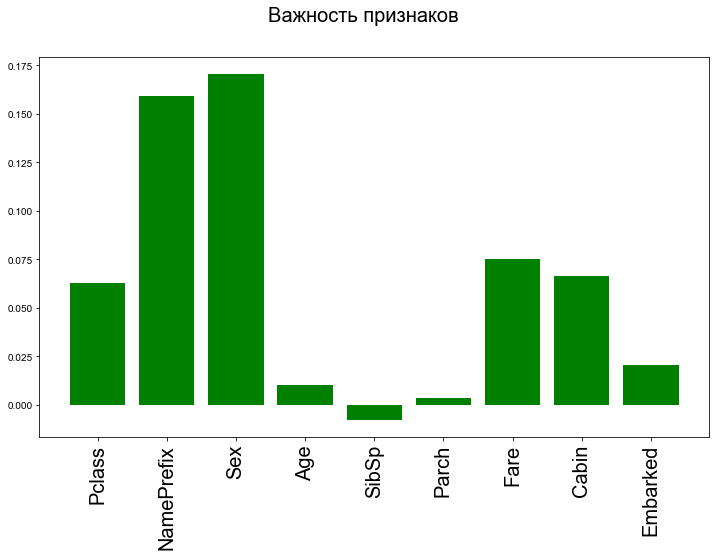

In [16]:
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols)), fi, color='g')
plt.xticks(np.arange(len(cols)), cols, rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

## 6
### Судя по графику самыми важными являются признаки пола и приставки к имени. Переберите все возможные пары признаков и выясните, является ли эта пара признаков наилучшей. Выведите на экран 10 лучших пар по убывнию их важности

In [17]:
def form_pairs_lists(data : pd.DataFrame):
    list_columns = []
    for c1 in range(len(data.columns)):
        for c2 in range(c1+1, len(data.columns)):
            list_columns.append((data.columns[c1],data.columns[c2]))
    return list_columns

pairs = form_pairs_lists(data1.loc[:, data1.columns != 'Survived'])
pairs

[('Pclass', 'NamePrefix'),
 ('Pclass', 'Sex'),
 ('Pclass', 'Age'),
 ('Pclass', 'SibSp'),
 ('Pclass', 'Parch'),
 ('Pclass', 'Fare'),
 ('Pclass', 'Cabin'),
 ('Pclass', 'Embarked'),
 ('NamePrefix', 'Sex'),
 ('NamePrefix', 'Age'),
 ('NamePrefix', 'SibSp'),
 ('NamePrefix', 'Parch'),
 ('NamePrefix', 'Fare'),
 ('NamePrefix', 'Cabin'),
 ('NamePrefix', 'Embarked'),
 ('Sex', 'Age'),
 ('Sex', 'SibSp'),
 ('Sex', 'Parch'),
 ('Sex', 'Fare'),
 ('Sex', 'Cabin'),
 ('Sex', 'Embarked'),
 ('Age', 'SibSp'),
 ('Age', 'Parch'),
 ('Age', 'Fare'),
 ('Age', 'Cabin'),
 ('Age', 'Embarked'),
 ('SibSp', 'Parch'),
 ('SibSp', 'Fare'),
 ('SibSp', 'Cabin'),
 ('SibSp', 'Embarked'),
 ('Parch', 'Fare'),
 ('Parch', 'Cabin'),
 ('Parch', 'Embarked'),
 ('Fare', 'Cabin'),
 ('Fare', 'Embarked'),
 ('Cabin', 'Embarked')]

In [18]:
#Let us calculate the best pairs!
# важность признаков
importance = {}
for c in pairs:
    if c == 'Survived': continue
    # пытаемся предсказать результат, используя только один столбец
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = model_selection.cross_val_predict(method, 
                                                       data1[[c[0],c[1]]],
                                                       data1['Survived'],
                                                       cv=cv)
    importance[c] = metrics.accuracy_score(data1['Survived'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])

# мы вычитаем из accuracy качество простой модели предсказания: 'все погибнут'
fi = fi - np.sum(data1['Survived']==0)/len(data1)

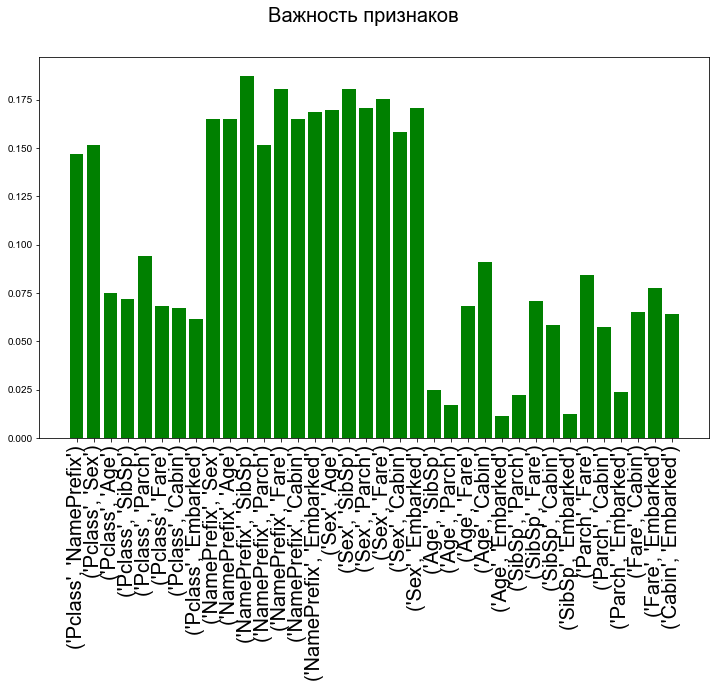

In [19]:
fig = plt.figure(figsize=(12,7))
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols)), fi, color='g')
plt.xticks(np.arange(len(cols)), cols, rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)

In [20]:
#So, the best pair, according to the graph, is "NamePrefix, SibSp"